Machine Description: <br>
- All of the cells are run on Floydhub cloud platform <br>
- The computation using GPU Tesla V80 <br>

In [1]:
'''
import dependencies needed for the next cell.
'''

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

from torchvision import utils



In [2]:
'''
set the hyperparameters of the model:
including batch size for test and training, number of epoch, and smoothing error
'''

TRAIN_BATCH_SIZE_1 = 10
TEST_BATCH_SIZE_1 = 4000
EPOCH_1 = 100
TINY_ERROR = 1e-5
CHECKPOINT_PERIOD = 10
DATA_PATH = "/floyd/input/skripsi_datasets_2/"

#check whether the computer has GPU
is_cuda = torch.cuda.is_available()

cuda = torch.device('cuda')
torch.manual_seed(1)

In [3]:
'''
Download the dataset using torchvision library
There are 2 Dataset CIFAR10 and CIFAR 100
The dataset then will be sampled as needed for the next tasks
'''

cifar_10 = datasets.CIFAR10(
        "/Downloads/",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        ),
    )


cifar_100 = datasets.CIFAR100(
            "/Downloads/",
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            ),
        )

        

Extracting /Downloads/cifar-10-python.tar.gz to /Downloads/


Extracting /Downloads/cifar-100-python.tar.gz to /Downloads/


Implement the helper methods and helper class for the next tasks. Helper method including metric computation, training model, test model, validate model. <br>
Helper class is implemented for Early stopping method for the next task. Credit for Stefano Nardo hor creating this class. You can find the original source code<br>
from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d.

In [4]:
'''
Helper class to perform early stopping for the next tasks
'''
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [5]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1_s

'''
Param: prediction of the model and ground truth
return: accuracy, sensitivity of each label, specificity of each label, and f1 score of each label
accuracy is computed by compared the number of the same value on prediction and ground truth
specificity and sensitivity is computed by looking up to the confusion matrix of each label
sensitivity =  tp / (tp + fn) 
specificity = tn / (tn + fp)
f1 score computed by: precision / recall
'''
def compute_metric(cprediction, ctarget):
    if torch.cuda.is_available():
        prediction = cprediction.cpu()
        target = ctarget.cpu()
    
    accuracy = accuracy_score(prediction, target)
    f1_sc = f1_s(prediction, target, labels=[i for i in range(10)], average=None)
    confusion_matrix = multilabel_confusion_matrix(prediction, target, labels=[i for i in range(10)])
    specificity = np.zeros(10)
    sensitivity = np.zeros(10) 
    
    for i in range(confusion_matrix.shape[0]):
        tn, fp, fn, tp = confusion_matrix[i].ravel()
        sensitivity[i] = tp / (tp + fn + 1e-4)
        specificity[i] = tn / (tn + fp + 1e-4)
    
    return accuracy, sensitivity, specificity, f1_sc

'''
parameter:
model, train loader, optimizer, loss function, and the current epoch
- this method trains a model for one epoch
- the model is set to train to unfreeze the weight parameter
- iterate over mini batch
- doing forward propagation
- compute the loss
- find the gradient w.r.t each of the parameter
- perform stochastic gradient descent
- keep the prediction and the ground truth, and compute the metric using method compute_metric
- if the epoch is a multiple of 5, output the metric score
- if the GPU exist, then train the model with GPU (cuda interface)
'''
def train_one_epoch(model, train_loader, optimizer, criterion, epoch):
    model = model.train()
    list_losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if is_cuda:
            data = data.cuda(cuda)
            target = target.cuda(cuda)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output + TINY_ERROR, target)
        loss.backward()
        optimizer.step()
        
        list_losses.append(loss.cpu().detach().numpy().item())
    
    return np.average(list_losses)
    

'''
Evaluate model during training phase. Dataset is obtained by splitting training set
The evaluation metric will be used the decide early stopping. Validation phase
only use one batch to evaluate the metric. The metric that is evaluated is cross entropy los function.
'''
def validate_model(model, valid_loader, criterion):
    model = model.eval()
    loss = None
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            if is_cuda:
                data = data.cuda(cuda)
                target = target.cuda(cuda)
            output = model(data)
            loss = criterion(output + TINY_ERROR, target)
        return loss


'''
save the model the path
'''
def save_checkpoint(model, path):
    torch.save(model.state_dict(), path)
    

'''
Method to train model for n epoch. Training phase including train the model, optimize the model,
validate the model, and choose the decision to do early_stop. if epoch reach the checkpoint period
display the loss and save the model.
'''
def train_model(model, train_loader, valid_loader, criterion, optimizer, early_stopping, EPOCH, path_checkpoint):
    model = model.train()
    epoch_loss = []
    
    for epoch in range(EPOCH):
        average_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
        epoch_loss.append(average_loss)
    
        if epoch % 2 == 0:
            print("Epoch-{}: Average-cross entropy Loss:{}".format(epoch, average_loss))
            
        if epoch % CHECKPOINT_PERIOD == 9:
            save_checkpoint(model, path_checkpoint + "-" + str(epoch)+".pt")
        
        if early_stopping != None:
            validation_loss = validate_model(model, valid_loader, criterion)
            if early_stopping.step(validation_loss):
                print("Early stopping on epoch-{}".format(epoch))
                print("Epoch-{}: Average-cross entropy Loss:{}".format(epoch, average_loss))
                break
        
    return np.array(epoch_loss)


'''
parameter: model and test loader
method to compute general loss
set the model to eval mode to freeze the weight parameter
calling this method will provide the model to compute the gradient for each of the computation
so it will reduce the usage of memory
use cuda interface to utilize GPU if the GPU exist
output the metric result
'''
def test_model(model, test_loader):
    model = model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if is_cuda:
                data = data.cuda(cuda)
                target = target.cuda(cuda)
            
            output = model(data)
            _, prediction = torch.max(output, 1)
            correct = (prediction == target).squeeze()
    
            accuracy, sensitivity, specificity, f1_score = compute_metric(prediction, target)
            
            return accuracy, sensitivity, specificity, f1_score

'''
Display test metric in a certain format.
Display accuracy, sensitivity, specificity, and f1_score
'''
def display_metric(accuracy, sensitivity, specificity, f1_score):
    print('Accuracy: {:.4}\n'.format(accuracy))
    print('Average sensitiviy: ' + str(np.average(sensitivity)) + '\n')
    print('Sensitivity for each class:\n')
    for i in range(sensitivity.shape[0]):
        print('    class {}: {:.4}\n'.format(i, sensitivity[i]))
    print('Average specificity: ' + str(np.average(specificity)) + '\n')
    print('Specificity for each class:\n')
    for i in range(specificity.shape[0]):
        print('    class {}: {:.4}\n'.format(i, specificity[i]))

    print('Average f1-score: ' + str(np.average(list(f1_score))) + '\n')
    print('f1-score for each class:\n')
    count = 0
    for f1 in f1_score:
        print('    class {}: {:.4}\n'.format(count, f1))
        count += 1
    print()

'''
Visualizing training loss for each epoch. The method needs one parameter
numpy array of average loss training for each epoch. utilize matplotlib to
plot the training loss.
'''
def visualize_training_loss(loss_epoch):
    training_epoch = np.arange(loss_epoch.size)
    plt.plot(training_epoch, loss_epoch, label='Training loss')
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
        

'''
This method return list of indexes of shuffled dataset 
with same amount of data for each of the class of dataset
At first it will shuffle an array of n consecutive numbers.
This array represent the index of original dataset. Then the method
will iterate the shuffled list of indexes one by one and filter each of the index.
If the index statisfied the criterion, it will be appended to the list of sampled indexes of dataset.
'''
def sample_dataset(dataset, dataset_size, num_of_class, num_each_class, size_of_sample):
    indexes = np.arange(dataset_size)
    np.random.shuffle(indexes)
    
    arr_each_class = [0] * num_of_class
    
    sampled_dataset_indexes = [] 
    
    for index in indexes:
        if len(sampled_dataset_indexes) >= size_of_sample:
            break
        
        label = dataset[index][1]
        if label < num_of_class and arr_each_class[label] < num_each_class:
            sampled_dataset_indexes.append(index)
            arr_each_class[label] += 1
        else:
            continue
    
    return sampled_dataset_indexes

TRANSFER LEARNING <br>
1. Bangun sebuah model CNN dengan arsitektur dasar sebagai berikut : <br>
- Convolutional Layer (25 maps, kernel 3x3)<br>
- Pooling Layer (2x2)<br>
- Activation Function (ReLU function)<br>
- Convolutional Layer (50 maps, kernel 3x3)<br>
- Pooling Layer (2x2)<br>
- Activation Function (ReLU function)<br>
- Convolutional Layer (100 maps, kernel 3x3)<br>
- Pooling Layer (2x2)<br>
- Activation Function (ReLU function)<br>
- Hidden Layer (100 neuron)<br>
- Activation Function (ReLU function)<br>
- Output Layer (10 kelas)<br>
- Activation Function (Softmax function)<br>
- Classification Result<br>
Dengan tambahan beberapa seperti :<br>
- Adam optimization<br>
- Early Stop<br>

In [6]:
'''
- The output layer is not explicitly implemented on the model's class
Instead, it is implicitly implemented whenever the model is on the 
training phase, test phase, or validation phase. The output layer 
is basically just an argmax layer to extract the class of data by select the highest value
from the output of softmax layer.


'''
FLATTEN_SIZE_1 = 4*4*100

class network_1(nn.Module):
    def __init__(self):
        super(network_1, self).__init__()
        self.convolutional1 = nn.Conv2d(3, 25, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu1 = nn.ReLU()
        self.convolutional2 = nn.Conv2d(25, 50, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu2 = nn.ReLU()
        self.convolutional3 = nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu3 = nn.ReLU()
        self.linear1 = nn.Linear(FLATTEN_SIZE_1, 100)
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(100, 10)
        self.softmax1 = nn.Softmax(dim=1)
        
        
        
    def forward(self, x):
        x = self.convolutional1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
        x = self.convolutional2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        x = self.convolutional3(x)
        x = self.maxpool3(x)
        x = self.relu3(x)
        x = x.view(-1, FLATTEN_SIZE_1)
        x = self.linear1(x)
        x = self.relu4(x)
        x = self.linear2(x)
        x = self.softmax1(x)
        
        return x

2. Implementasi model CNN tersebut pada dataset CIFAR 10 (ambil random hanya 1000 citra per kelas) <br>
dengan inisial epoch = 100, batch number = 10, learning rate= 0.1, serta ratio data train dan data test sebanyak 60% : 40%.

In [7]:
'''
initialize number of class, number of each class, the size of dataset, and size of the sample.
then got the train indexes and the test indexes. Use the train indexes and test indexes to get
the train loader and test loader.
'''
VALID_BATCH_SIZE = 1000

num_of_class = 10
num_each_class = 1000
dataset_size = 50000
size_of_sample = 10000

dataset_indexes = sample_dataset(cifar_10, dataset_size, num_of_class, num_each_class, size_of_sample)

train_indexes = dataset_indexes[:int(size_of_sample * 0.6)]
test_indexes = dataset_indexes[int(0.6 * size_of_sample):]

valid_indexes = test_indexes[:1000]
test_indexes = test_indexes[1000:]

valid_loader_1 = torch.utils.data.DataLoader(dataset=cifar_10, shuffle=False, batch_size=VALID_BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(valid_indexes))
train_loader_1 = torch.utils.data.DataLoader(dataset=cifar_10, shuffle=False, batch_size=TRAIN_BATCH_SIZE_1, sampler=torch.utils.data.SubsetRandomSampler(train_indexes))
test_loader_1 = torch.utils.data.DataLoader(dataset=cifar_10, shuffle=False, batch_size=TEST_BATCH_SIZE_1, sampler=torch.utils.data.SubsetRandomSampler(test_indexes))

In [8]:
'''
initialize the model and train it. Use the helper method to train the model
'''
lr_1 = 0.1
model_1 =  network_1()
early_stopping_1 = EarlyStopping(patience=20, mode='min', min_delta=1e-4)

if is_cuda:
    model_1 = model_1.cuda(cuda)
  
criterion_model_1 = nn.CrossEntropyLoss()
optimizer_model_1 = optim.Adam(model_1.parameters(), lr=lr_1)

train_and_loss_1 = train_model(model_1, train_loader_1, valid_loader_1, criterion_model_1, optimizer_model_1, early_stopping_1, EPOCH_1, "model_1")

Epoch-0: Average-cross entropy Loss:2.357053814729055
Epoch-2: Average-cross entropy Loss:2.355983680089315
Epoch-4: Average-cross entropy Loss:2.355983672142029
Epoch-6: Average-cross entropy Loss:2.355983681678772
Epoch-8: Average-cross entropy Loss:2.3559836741288502
Epoch-10: Average-cross entropy Loss:2.355983680486679
Epoch-12: Average-cross entropy Loss:2.355983679294586
Epoch-14: Average-cross entropy Loss:2.3559836769104003
Epoch-16: Average-cross entropy Loss:2.3559836769104003
Epoch-18: Average-cross entropy Loss:2.355983677705129
Epoch-20: Average-cross entropy Loss:2.355983678499858
Early stopping on epoch-20
Epoch-20: Average-cross entropy Loss:2.355983678499858


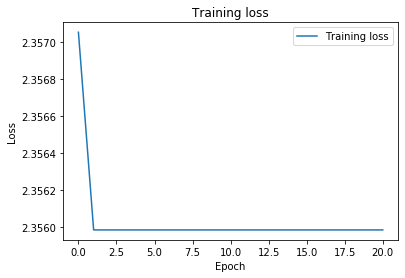

Accuracy: 0.08867

Average sensitiviy: 0.00886666637111112

Sensitivity for each class:

    class 0: 0.0

    class 1: 0.0

    class 2: 0.08867

    class 3: 0.0

    class 4: 0.0

    class 5: 0.0

    class 6: 0.0

    class 7: 0.0

    class 8: 0.0

    class 9: 0.0

Average specificity: 0.8088666397044454

Specificity for each class:

    class 0: 0.8903

    class 1: 0.9017

    class 2: 0.0

    class 3: 0.892

    class 4: 0.9167

    class 5: 0.893

    class 6: 0.901

    class 7: 0.9033

    class 8: 0.8963

    class 9: 0.8943

Average f1-score: 0.016289038579301897

f1-score for each class:

    class 0: 0.0

    class 1: 0.0

    class 2: 0.1629

    class 3: 0.0

    class 4: 0.0

    class 5: 0.0

    class 6: 0.0

    class 7: 0.0

    class 8: 0.0

    class 9: 0.0




In [22]:
#save and test the model
file_location_model_1 = "model_final_1.pt"
save_checkpoint(model_1, file_location_model_1)

#visualize training error
visualize_training_loss(train_and_loss_1)

#display test metric
accuracy, sensitivity, specificity, f1_score = test_model(model_1, test_loader_1)
display_metric(accuracy, sensitivity, specificity, f1_score)

3. Lakukan skenario eksperimen untuk mendapatkan metrik evaluasi optimal (akurasi,sensitivity, specifity, dan f1-score) dengan mengubah parameter yaitu:<br>
(a) Mengubah epoch, dengan learning rate = 0.1 dan batch number = 10 <br>
(b) Mengubah jumlah batch number dengan epoch optimal dari skenario (a) dan <br>
learning rate = 0.1 <br>
(c) Mengubah learning rate dengan epoch optimal dari skenario (a) dan jumlah
batch number optimal dari skenario (b). <br>
<br>
4. Simpan checkpoint dari tiap interval epoch dan model final dari proses training dari <br>
model CNN dengan parameter optimal yang diperoleh dari skenario agar bisa <br>
digunakan kembali untuk proses training selanjutnya. <br>
<br>
5. Visualisasikan error dari proses training yang diperoleh dari tiap epoch dan <br>
tampilkan matrik evaluasi (akurasi, sensitivity, specifity, dan f1-score) dari data test. <br>

In [10]:
EPOCH_2 = 120
model_2 =  network_1()

if is_cuda:
    model_2 = model_2.cuda(cuda)

criterion_model_2 = nn.CrossEntropyLoss()
optimizer_model_2 = optim.Adam(model_2.parameters(), lr=lr_1)

train_and_loss_2 = train_model(model_2, train_loader_1, None, criterion_model_2, optimizer_model_2, None, EPOCH_2, "model_2")

Epoch-0: Average-cross entropy Loss:2.360725847085317
Epoch-2: Average-cross entropy Loss:2.360150343179703
Epoch-4: Average-cross entropy Loss:2.3601503483454387
Epoch-6: Average-cross entropy Loss:2.3601503439744316
Epoch-8: Average-cross entropy Loss:2.360150342384974
Epoch-10: Average-cross entropy Loss:2.3601503415902454
Epoch-12: Average-cross entropy Loss:2.3601503443717955
Epoch-14: Average-cross entropy Loss:2.360150343577067
Epoch-16: Average-cross entropy Loss:2.3601503479480743
Epoch-18: Average-cross entropy Loss:2.3601503419876098
Epoch-20: Average-cross entropy Loss:2.3601503427823385
Epoch-22: Average-cross entropy Loss:2.3601503400007884
Epoch-24: Average-cross entropy Loss:2.3601503481467563
Epoch-26: Average-cross entropy Loss:2.3601503495375313
Epoch-28: Average-cross entropy Loss:2.3601503415902454
Epoch-30: Average-cross entropy Loss:2.36015034755071
Epoch-32: Average-cross entropy Loss:2.360150343179703
Epoch-34: Average-cross entropy Loss:2.3601503449678423
Epoc

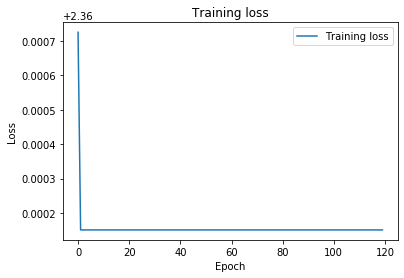

Accuracy: 0.09833

Average sensitiviy: 0.009833333005555566

Sensitivity for each class:

    class 0: 0.0

    class 1: 0.09833

    class 2: 0.0

    class 3: 0.0

    class 4: 0.0

    class 5: 0.0

    class 6: 0.0

    class 7: 0.0

    class 8: 0.0

    class 9: 0.0

Average specificity: 0.8098333063388898

Specificity for each class:

    class 0: 0.8903

    class 1: 0.0

    class 2: 0.9113

    class 3: 0.892

    class 4: 0.9167

    class 5: 0.893

    class 6: 0.901

    class 7: 0.9033

    class 8: 0.8963

    class 9: 0.8943

Average f1-score: 0.017905918057663124

f1-score for each class:

    class 0: 0.0

    class 1: 0.1791

    class 2: 0.0

    class 3: 0.0

    class 4: 0.0

    class 5: 0.0

    class 6: 0.0

    class 7: 0.0

    class 8: 0.0

    class 9: 0.0




In [21]:
#save and test the model
file_location_model_2 = "model_final_2.pt"
save_checkpoint(model_2, file_location_model_2)

#visualize training error
visualize_training_loss(train_and_loss_2)

#display test metric
accuracy, sensitivity, specificity, f1_score = test_model(model_2, test_loader_1)
display_metric(accuracy, sensitivity, specificity, f1_score)

In [13]:
TRAIN_BATCH_SIZE_2 = 100
train_loader_2 = torch.utils.data.DataLoader(dataset=cifar_10, shuffle=False, batch_size=TRAIN_BATCH_SIZE_2, sampler=torch.utils.data.SubsetRandomSampler(train_indexes))
test_loader_2 = torch.utils.data.DataLoader(dataset=cifar_10, shuffle=False, batch_size=TEST_BATCH_SIZE_1, sampler=torch.utils.data.SubsetRandomSampler(test_indexes))

In [15]:
EPOCH_3 = 120
model_3 =  network_1()

if is_cuda:
    model_3 = model_3.cuda(cuda)
    
criterion_model_3 = nn.CrossEntropyLoss()
optimizer_model_3 = optim.Adam(model_3.parameters(), lr=lr_1)
    
train_and_loss_3 = train_model(model_3, train_loader_2, None, criterion_model_3, optimizer_model_3, None, EPOCH_3, "model_3")

Epoch-0: Average-cross entropy Loss:2.3620065371195476
Epoch-2: Average-cross entropy Loss:2.362484077612559
Epoch-4: Average-cross entropy Loss:2.362484089533488
Epoch-6: Average-cross entropy Loss:2.362484089533488
Epoch-8: Average-cross entropy Loss:2.362484085559845
Epoch-10: Average-cross entropy Loss:2.362484085559845
Epoch-12: Average-cross entropy Loss:2.3624840935071307
Epoch-14: Average-cross entropy Loss:2.362484085559845
Epoch-16: Average-cross entropy Loss:2.362484097480774
Epoch-18: Average-cross entropy Loss:2.362484097480774
Epoch-20: Average-cross entropy Loss:2.362484085559845
Epoch-22: Average-cross entropy Loss:2.362484085559845
Epoch-24: Average-cross entropy Loss:2.362484089533488
Epoch-26: Average-cross entropy Loss:2.362484077612559
Epoch-28: Average-cross entropy Loss:2.362484097480774
Epoch-30: Average-cross entropy Loss:2.362484081586202
Epoch-32: Average-cross entropy Loss:2.362484077612559
Epoch-34: Average-cross entropy Loss:2.362484081586202
Epoch-36: Ave

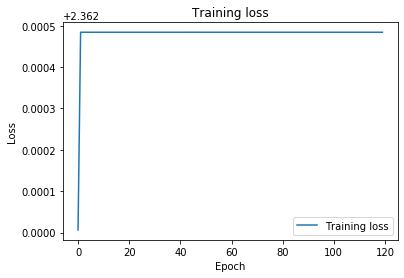

Accuracy: 0.1057

Average sensitiviy: 0.010566666314444455

Sensitivity for each class:

    class 0: 0.0

    class 1: 0.0

    class 2: 0.0

    class 3: 0.0

    class 4: 0.0

    class 5: 0.0

    class 6: 0.0

    class 7: 0.0

    class 8: 0.0

    class 9: 0.1057

Average specificity: 0.8105666396477785

Specificity for each class:

    class 0: 0.8903

    class 1: 0.9017

    class 2: 0.9113

    class 3: 0.892

    class 4: 0.9167

    class 5: 0.893

    class 6: 0.901

    class 7: 0.9033

    class 8: 0.8963

    class 9: 0.0

Average f1-score: 0.019113656918902624

f1-score for each class:

    class 0: 0.0

    class 1: 0.0

    class 2: 0.0

    class 3: 0.0

    class 4: 0.0

    class 5: 0.0

    class 6: 0.0

    class 7: 0.0

    class 8: 0.0

    class 9: 0.1911




In [20]:
#save and test the model
file_location_model_3 = "model_final_3.pt"
save_checkpoint(model_3, file_location_model_3)

#visualize training error
visualize_training_loss(train_and_loss_3)

#display test metric
accuracy, sensitivity, specificity, f1_score = test_model(model_3, test_loader_2)
display_metric(accuracy, sensitivity, specificity, f1_score)

In [23]:
EPOCH_4 = 120
lr_2 = 0.0001
model_4 = network_1()

if is_cuda:
    model_4 = model_4.cuda(cuda)

criterion_model_4 = nn.CrossEntropyLoss()
optimizer_model_4 = optim.Adam(model_4.parameters(), lr=lr_2)

train_and_loss_4 = train_model(model_4, train_loader_2, None, criterion_model_4, optimizer_model_4, None, EPOCH_4, "model_4")

Epoch-0: Average-cross entropy Loss:2.298665543397268
Epoch-2: Average-cross entropy Loss:2.183494202295939
Epoch-4: Average-cross entropy Loss:2.1558603286743163
Epoch-6: Average-cross entropy Loss:2.1317097226778667
Epoch-8: Average-cross entropy Loss:2.1200111071268717
Epoch-10: Average-cross entropy Loss:2.1086010098457337
Epoch-12: Average-cross entropy Loss:2.094999059041341
Epoch-14: Average-cross entropy Loss:2.088266011079152
Epoch-16: Average-cross entropy Loss:2.0796248535315196
Epoch-18: Average-cross entropy Loss:2.074263139565786
Epoch-20: Average-cross entropy Loss:2.0674545049667357
Epoch-22: Average-cross entropy Loss:2.058255926767985
Epoch-24: Average-cross entropy Loss:2.05321271220843
Epoch-26: Average-cross entropy Loss:2.0467239797115324
Epoch-28: Average-cross entropy Loss:2.039867111047109
Epoch-30: Average-cross entropy Loss:2.035265237092972
Epoch-32: Average-cross entropy Loss:2.028705859184265
Epoch-34: Average-cross entropy Loss:2.0227427383263907
Epoch-36

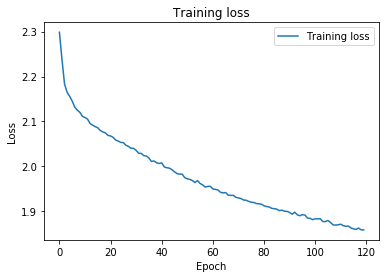

Accuracy: 0.4767

Average sensitiviy: 0.47734471156850977

Sensitivity for each class:

    class 0: 0.6404

    class 1: 0.5549

    class 2: 0.3452

    class 3: 0.3067

    class 4: 0.3651

    class 5: 0.4643

    class 6: 0.5041

    class 7: 0.4711

    class 8: 0.5785

    class 9: 0.5433

Average specificity: 0.9420219182207287

Specificity for each class:

    class 0: 0.934

    class 1: 0.956

    class 2: 0.9266

    class 3: 0.9215

    class 4: 0.9497

    class 5: 0.9218

    class 6: 0.9578

    class 7: 0.9495

    class 8: 0.954

    class 9: 0.9493

Average f1-score: 0.4699909496332613

f1-score for each class:

    class 0: 0.5242

    class 1: 0.5765

    class 2: 0.2673

    class 3: 0.3343

    class 4: 0.4071

    class 5: 0.3817

    class 6: 0.5586

    class 7: 0.5008

    class 8: 0.5912

    class 9: 0.5583




In [24]:
#save and test the model
file_location_model_4 = "model_final_4.pt"
save_checkpoint(model_4, file_location_model_4)

#visualize training error
visualize_training_loss(train_and_loss_4)

#display test metric
accuracy, sensitivity, specificity, f1_score = test_model(model_4, test_loader_2)
display_metric(accuracy, sensitivity, specificity, f1_score)

6. Gunakan pre-trained model yg telah dibuat tersebut untuk diimplementasikan pada <br>
dataset CIFAR 100 untuk kelas 1 hingga kelas 10 (masing-masing kelas terdiri dari <br>
100 citra) dengan rasio data train dan data test sebanyak 60% : 40%. Kemudian <br>
hitung matrik evaluasi (akurasi, sensitivity, specifity, dan f1-score) dari data train <br>
dan data test.

In [8]:
'''
initialize number of class, number of each class, the size of dataset, and size of the sample.
then got the train indexes and the test indexes. Use the train indexes and test indexes to get
the train loader and test loader.
'''
num_of_class_2 = 10
num_each_class_2 = 100
dataset_size_2 = 50000
size_of_sample_2 = 1000
TEST_BATCH_SIZE_2 = 400
TRAIN_BATCH_SIZE_2 = 100

dataset_indexes_2 = sample_dataset(cifar_100, dataset_size_2, num_of_class_2, num_each_class_2, size_of_sample_2)

train_indexes_2 = dataset_indexes_2[:int(size_of_sample_2 * 0.6)]
test_indexes_2 = dataset_indexes_2[int(0.6 * size_of_sample_2):]

train_loader_3 = torch.utils.data.DataLoader(dataset=cifar_100, shuffle=False, batch_size=TRAIN_BATCH_SIZE_2, sampler=torch.utils.data.SubsetRandomSampler(train_indexes_2))
test_loader_3 = torch.utils.data.DataLoader(dataset=cifar_100, shuffle=False, batch_size=TEST_BATCH_SIZE_2, sampler=torch.utils.data.SubsetRandomSampler(test_indexes_2))

In [31]:
#train model pretrain 1
EPOCH_PRETRAIN_1 = 200
model_pretrain_1 = network_1()
model_pretrain_1.load_state_dict(torch.load("model_final_4.pt"))

if is_cuda:
    model_pretrain_1 = model_pretrain_1.cuda(cuda)
    
criterion_model_pretrain_1 = nn.CrossEntropyLoss()
optimizer_model_pretrain_1 = optim.Adam(model_pretrain_1.parameters(), lr=lr_2)

train_and_loss_5 = train_model(model_pretrain_1, train_loader_3, None, criterion_model_pretrain_1, optimizer_model_pretrain_1, None, EPOCH_PRETRAIN_1, "model_pretrain_1")

Epoch-0: Average-cross entropy Loss:2.3216296831766763
Epoch-2: Average-cross entropy Loss:2.2730205059051514
Epoch-4: Average-cross entropy Loss:2.2526535193125405
Epoch-6: Average-cross entropy Loss:2.2377266883850098
Epoch-8: Average-cross entropy Loss:2.2269545793533325
Epoch-10: Average-cross entropy Loss:2.219796816507975
Epoch-12: Average-cross entropy Loss:2.2134652137756348
Epoch-14: Average-cross entropy Loss:2.207617441813151
Epoch-16: Average-cross entropy Loss:2.2022225856781006
Epoch-18: Average-cross entropy Loss:2.1967601776123047
Epoch-20: Average-cross entropy Loss:2.1891836325327554
Epoch-22: Average-cross entropy Loss:2.1877360741297402
Epoch-24: Average-cross entropy Loss:2.1834348837534585
Epoch-26: Average-cross entropy Loss:2.1766148805618286
Epoch-28: Average-cross entropy Loss:2.173719565073649
Epoch-30: Average-cross entropy Loss:2.170170863469442
Epoch-32: Average-cross entropy Loss:2.1683870951334634
Epoch-34: Average-cross entropy Loss:2.1660331090291343
E

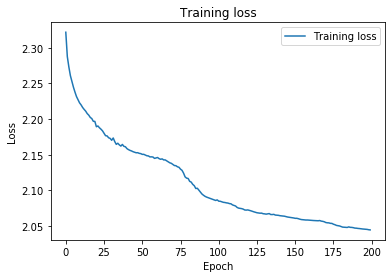

Accuracy: 0.1775

Average sensitiviy: 0.12029102624852998

Sensitivity for each class:

    class 0: 0.0

    class 1: 0.2667

    class 2: 0.0

    class 3: 0.1444

    class 4: 0.137

    class 5: 0.2289

    class 6: 0.2239

    class 7: 0.0

    class 8: 0.09091

    class 9: 0.1111

Average specificity: 0.909928151402488

Specificity for each class:

    class 0: 0.9144

    class 1: 0.9465

    class 2: 0.9013

    class 3: 0.9226

    class 4: 0.9205

    class 5: 0.9338

    class 6: 0.9069

    class 7: 0.8636

    class 8: 0.9023

    class 9: 0.8875

Average f1-score: 0.13554669737967875

f1-score for each class:

    class 0: 0.0

    class 1: 0.3158

    class 2: 0.0

    class 3: 0.2047

    class 4: 0.1835

    class 5: 0.3089

    class 6: 0.2655

    class 7: 0.0

    class 8: 0.04

    class 9: 0.03704




In [32]:
#save and test the model
file_location_model_pretrain_1 = "model_final_pretrain_1.pt"
save_checkpoint(model_pretrain_1, file_location_model_pretrain_1)

#visualize training error
visualize_training_loss(train_and_loss_5)

#display test metric
accuracy, sensitivity, specificity, f1_score = test_model(model_pretrain_1, test_loader_3)
display_metric(accuracy, sensitivity, specificity, f1_score)

In [12]:
#train model pretrain 1 on train set
FULL_TRAIN_BATCH_SIZE_2 = 600
full_train_loader_3 = torch.utils.data.DataLoader(dataset=cifar_100, shuffle=False, batch_size=FULL_TRAIN_BATCH_SIZE_2, sampler=torch.utils.data.SubsetRandomSampler(train_indexes_2))

model_pretrain_1 = network_1()
if is_cuda:
    model_pretrain_1 = model_pretrain_1.cuda(cuda)
    
model_pretrain_1.load_state_dict(torch.load("model_final_pretrain_1.pt"))
accuracy, sensitivity, specificity, f1_score = test_model(model_pretrain_1, full_train_loader_3)
display_metric(accuracy, sensitivity, specificity, f1_score)

Accuracy: 0.2533

Average sensitiviy: 0.1827633196440358

Sensitivity for each class:

    class 0: 0.0

    class 1: 0.3833

    class 2: 0.0

    class 3: 0.1797

    class 4: 0.3

    class 5: 0.2695

    class 6: 0.2698

    class 7: 0.2

    class 8: 0.1538

    class 9: 0.07143

Average specificity: 0.9187998638236754

Specificity for each class:

    class 0: 0.9197

    class 1: 0.9315

    class 2: 0.8761

    class 3: 0.9258

    class 4: 0.936

    class 5: 0.9477

    class 6: 0.943

    class 7: 0.9042

    class 8: 0.8995

    class 9: 0.9044

Average f1-score: 0.18530052316348514

f1-score for each class:

    class 0: 0.0

    class 1: 0.3833

    class 2: 0.0

    class 3: 0.2473

    class 4: 0.3704

    class 5: 0.3744

    class 6: 0.3636

    class 7: 0.03175

    class 8: 0.05405

    class 9: 0.02817




7. Buat arsitektur CNN yang baru dengan menggunakan semua hidden layer <br>
pretrained dari model sebelumnya, lakukan freezing pada semua hidden layer <br>
tersebut, lalu ganti layer output softmax dengan layer baru.

In [13]:
'''
The architecture of original fully connected layer
The input size is the dimension of the input (grayscale CIFAR) which is 32x32
'''
FLATTEN_SIZE_1 = 4*4*100

class network_2(nn.Module):
    def __init__(self):
        super(network_2, self).__init__()
        self.convolutional1 = nn.Conv2d(3, 25, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu1 = nn.ReLU()
        self.convolutional2 = nn.Conv2d(25, 50, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu2 = nn.ReLU()
        self.convolutional3 = nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu3 = nn.ReLU()
        self.linear1 = nn.Linear(FLATTEN_SIZE_1, 100)
        self.relu4 = nn.ReLU()
        self.new_linear2 = nn.Linear(100, 10)
        self.softmax1 = nn.Softmax(dim=1)
        
        
        
    def forward(self, x):
        x = self.convolutional1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
        x = self.convolutional2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        x = self.convolutional3(x)
        x = self.maxpool3(x)
        x = self.relu3(x)
        x = x.view(-1, FLATTEN_SIZE_1)
        x = self.linear1(x)
        x = self.relu4(x)
        x = self.new_linear2(x)
        x = self.softmax1(x)
        
        return x
    
def transfer_parameter(model, model_dict, trained_dict):
    filtered_trained_dict = {k:v for k, v in trained_dict.items() if k in model_dict}
    model_dict.update(filtered_trained_dict)
    model.load_state_dict(model_dict)

def freeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = False
        

In [54]:
#transfer parameter from model 4
model_pretrain_2 = network_2()
model_pretrain_2_parameter = model_pretrain_2.named_parameters()
dict_pretrain_2 = dict(model_pretrain_2_parameter)
load_trained = torch.load("model_final_4.pt")
trained_dict = dict(load_trained)
transfer_parameter(model_pretrain_2, dict_pretrain_2, trained_dict)
freeze_all_layers(model_pretrain_2)

#unfreeze output layer
model_pretrain_2.new_linear2.weight.requires_grad = True
model_pretrain_2.new_linear2.bias.requires_grad = True

8. Implementasikan model poin (7) pada dataset CIFAR 100 untuk kelas 1 hingga kelas <br>
10 dengan rasio data train dan data test sebanyak 60% : 40%. Kemudian hitung <br>
matrik evaluasi (akurasi, sensitivity, specifity, dan f1-score) dari data train dan data <br>
test. <br>


In [14]:
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 10000

#train_dataset
num_of_class_train = 10
num_each_class_train = 500
dataset_size_train = 50000
size_of_sample_train = 5000

indexes_train = sample_dataset(cifar_100, dataset_size_train, num_of_class_train, num_each_class_train, size_of_sample_train)
train_loader_4 = torch.utils.data.DataLoader(dataset=cifar_100, shuffle=False, batch_size=TRAIN_BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(indexes_train))


#test_dataset
num_of_class_test = 10
num_each_class_test = 100
dataset_size_test = 10000
size_of_sample_test = 5000

cifar_100_test = datasets.CIFAR100(
            "/Downloads/",
            train=False,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            ),
        )

indexes_test = sample_dataset(cifar_100_test, dataset_size_test, num_of_class_test, num_each_class_test, size_of_sample_test)
test_loader_4 = torch.utils.data.DataLoader(dataset=cifar_100_test, shuffle=False, batch_size=TEST_BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(indexes_test))

Files already downloaded and verified


In [56]:
#train model pretrain 2
if is_cuda:
    model_pretrain_2 = model_pretrain_2.cuda(cuda)
    
EPOCH_PRETRAIN_2 = 150
criterion_model_pretrain_2 = nn.CrossEntropyLoss()
optimizer_model_pretrain_2 = optim.Adam(model_pretrain_2.parameters(), lr=lr_2)

train_and_loss_6 = train_model(model_pretrain_2, train_loader_4, None, criterion_model_pretrain_2, optimizer_model_pretrain_2, None, EPOCH_PRETRAIN_2, 'model_pretrain_2')

Epoch-0: Average-cross entropy Loss:2.3043142461776736
Epoch-2: Average-cross entropy Loss:2.266190948486328
Epoch-4: Average-cross entropy Loss:2.2380852270126343
Epoch-6: Average-cross entropy Loss:2.2194687843322756
Epoch-8: Average-cross entropy Loss:2.204124355316162
Epoch-10: Average-cross entropy Loss:2.1907897663116453
Epoch-12: Average-cross entropy Loss:2.1793342447280883
Epoch-14: Average-cross entropy Loss:2.169667820930481
Epoch-16: Average-cross entropy Loss:2.162414813041687
Epoch-18: Average-cross entropy Loss:2.156735315322876
Epoch-20: Average-cross entropy Loss:2.15004150390625
Epoch-22: Average-cross entropy Loss:2.142788681983948
Epoch-24: Average-cross entropy Loss:2.134385471343994
Epoch-26: Average-cross entropy Loss:2.1275934553146363
Epoch-28: Average-cross entropy Loss:2.122262601852417
Epoch-30: Average-cross entropy Loss:2.118214979171753
Epoch-32: Average-cross entropy Loss:2.1156613540649416
Epoch-34: Average-cross entropy Loss:2.1127179479599
Epoch-36: A

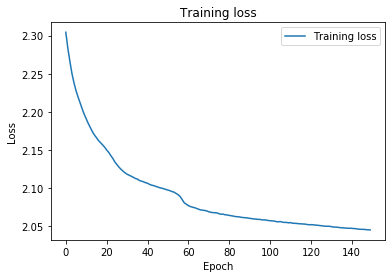

Accuracy: 0.398

Average sensitiviy: 0.33335623535050746

Sensitivity for each class:

    class 0: 0.4828

    class 1: 0.5039

    class 2: 0.3361

    class 3: 0.0

    class 4: 0.2709

    class 5: 0.4035

    class 6: 0.3433

    class 7: 0.0

    class 8: 0.4545

    class 9: 0.5385

Average specificity: 0.934217406343142

Specificity for each class:

    class 0: 0.9649

    class 1: 0.9588

    class 2: 0.9319

    class 3: 0.8997

    class 4: 0.9435

    class 5: 0.9391

    class 6: 0.9376

    class 7: 0.9

    class 8: 0.9296

    class 9: 0.9371

Average f1-score: 0.3554097604261

f1-score for each class:

    class 0: 0.5714

    class 1: 0.5639

    class 2: 0.3653

    class 3: 0.0

    class 4: 0.363

    class 5: 0.4299

    class 6: 0.3932

    class 7: 0.0

    class 8: 0.3955

    class 9: 0.4719




In [57]:
#save and test the model
file_location_model_pretrain_2 = "model_final_pretrain_2.pt"
save_checkpoint(model_pretrain_2, file_location_model_pretrain_2)

#visualize training error
visualize_training_loss(train_and_loss_6)

#display test metric
accuracy, sensitivity, specificity, f1_score = test_model(model_pretrain_2, test_loader_4)
display_metric(accuracy, sensitivity, specificity, f1_score)

In [15]:
#test the model on the train set
FULL_TRAIN_BATCH_SIZE = 5000
full_train_loader_4 = torch.utils.data.DataLoader(dataset=cifar_100, shuffle=False, batch_size=FULL_TRAIN_BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(indexes_train))

model_pretrain_2 = network_2()
if is_cuda:
    model_pretrain_2 = model_pretrain_2.cuda(cuda)

#display metric on train set
model_pretrain_2.load_state_dict(torch.load("model_final_pretrain_2.pt"))
accuracy, sensitivity, specificity, f1_score = test_model(model_pretrain_2, full_train_loader_4)
display_metric(accuracy, sensitivity, specificity, f1_score)

Accuracy: 0.4242

Average sensitiviy: 0.38444100478537535

Sensitivity for each class:

    class 0: 0.5431

    class 1: 0.5101

    class 2: 0.3964

    class 3: 0.2667

    class 4: 0.2915

    class 5: 0.4548

    class 6: 0.336

    class 7: 0.0

    class 8: 0.4499

    class 9: 0.5959

Average specificity: 0.9371660000511728

Specificity for each class:

    class 0: 0.9594

    class 1: 0.9605

    class 2: 0.9414

    class 3: 0.9005

    class 4: 0.949

    class 5: 0.9492

    class 6: 0.9416

    class 7: 0.9

    class 8: 0.9279

    class 9: 0.9421

Average f1-score: 0.3813422956316826

f1-score for each class:

    class 0: 0.5885

    class 1: 0.5739

    class 2: 0.4367

    class 3: 0.01553

    class 4: 0.391

    class 5: 0.4995

    class 6: 0.4032

    class 7: 0.0

    class 8: 0.382

    class 9: 0.523




9. Lalu lakukan unfreeze pada satu hidden layer (conv-pool-actv) paling atas dan <br>
lakukan kembali proses training menggunakan deskripsi data yang sama dengan <br>
poin (8). Bagaimana hasil yang diperoleh dari perubahan ini? <br>

In [58]:
#model pretrain 3 which used parameters that are transfered from the model_4
model_pretrain_3 = network_2()
model_pretrain_3_parameter = model_pretrain_3.named_parameters()
dict_pretrain_3 = dict(model_pretrain_3_parameter)
load_trained_2 = torch.load("model_final_4.pt")
trained_dict_2 = dict(load_trained_2)
transfer_parameter(model_pretrain_3, dict_pretrain_3, trained_dict_2)
freeze_all_layers(model_pretrain_3)

#unfreeze conv layer
model_pretrain_3.convolutional3.weight.requires_grad = True
model_pretrain_3.convolutional3.bias.requires_grad = True

#unfreeze output layer
model_pretrain_3.new_linear2.weight.requires_grad = True
model_pretrain_3.new_linear2.bias.requires_grad = True

In [60]:
#train model pretrain 3
if is_cuda:
    model_pretrain_3 = model_pretrain_3.cuda(cuda)
    
EPOCH_PRETRAIN_3 = 150
criterion_model_pretrain_3 = nn.CrossEntropyLoss()
optimizer_model_pretrain_3 = optim.Adam(model_pretrain_3.parameters(), lr=lr_2)

train_and_loss_7 = train_model(model_pretrain_3, train_loader_4, None, criterion_model_pretrain_3, optimizer_model_pretrain_3, None, EPOCH_PRETRAIN_3, 'model_pretrain_3')

Epoch-0: Average-cross entropy Loss:2.3439536809921266
Epoch-2: Average-cross entropy Loss:2.2805286693572997
Epoch-4: Average-cross entropy Loss:2.262702798843384
Epoch-6: Average-cross entropy Loss:2.250662980079651
Epoch-8: Average-cross entropy Loss:2.2327695512771606
Epoch-10: Average-cross entropy Loss:2.2081324005126954
Epoch-12: Average-cross entropy Loss:2.1951750564575194
Epoch-14: Average-cross entropy Loss:2.1835766220092774
Epoch-16: Average-cross entropy Loss:2.173053102493286
Epoch-18: Average-cross entropy Loss:2.164235062599182
Epoch-20: Average-cross entropy Loss:2.157683653831482
Epoch-22: Average-cross entropy Loss:2.153209056854248
Epoch-24: Average-cross entropy Loss:2.1489376640319824
Epoch-26: Average-cross entropy Loss:2.145503296852112
Epoch-28: Average-cross entropy Loss:2.1426382732391356
Epoch-30: Average-cross entropy Loss:2.1385263204574585
Epoch-32: Average-cross entropy Loss:2.136166186332703
Epoch-34: Average-cross entropy Loss:2.1330604267120363
Epoch

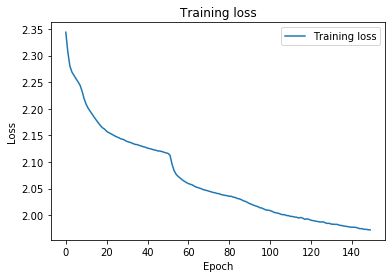

Accuracy: 0.458

Average sensitiviy: 0.38590067362230274

Sensitivity for each class:

    class 0: 0.0

    class 1: 0.5396

    class 2: 0.3684

    class 3: 0.3169

    class 4: 0.0

    class 5: 0.5431

    class 6: 0.3622

    class 7: 0.4811

    class 8: 0.481

    class 9: 0.7667

Average specificity: 0.9410502499336337

Specificity for each class:

    class 0: 0.9

    class 1: 0.971

    class 2: 0.9481

    class 3: 0.9359

    class 4: 0.9

    class 5: 0.9581

    class 6: 0.9381

    class 7: 0.9452

    class 8: 0.9715

    class 9: 0.9426

Average f1-score: 0.40918729284875666

f1-score for each class:

    class 0: 0.0

    class 1: 0.6276

    class 2: 0.4444

    class 3: 0.3719

    class 4: 0.0

    class 5: 0.5833

    class 6: 0.4053

    class 7: 0.4951

    class 8: 0.5891

    class 9: 0.575




In [61]:
#save and test the model
file_location_model_pretrain_3 = "model_final_pretrain_3.pt"
save_checkpoint(model_pretrain_3, file_location_model_pretrain_3)

#visualize training error
visualize_training_loss(train_and_loss_7)

#display test metric
accuracy, sensitivity, specificity, f1_score = test_model(model_pretrain_3, test_loader_4)
display_metric(accuracy, sensitivity, specificity, f1_score)

In [16]:
#test the entire of training set once again with the final parameters of model pretrain 3
model_pretrain_3 = network_2()
model_pretrain_3.load_state_dict(torch.load("model_final_pretrain_3.pt"))

if is_cuda:
    model_pretrain_3 = model_pretrain_3.cuda(cuda)

#evaluate model by accuracy, sensitivity, specificity, and f1 score
accuracy, sensitivity, specificity, f1_score = test_model(model_pretrain_3, full_train_loader_4)
display_metric(accuracy, sensitivity, specificity, f1_score)

Accuracy: 0.5052

Average sensitiviy: 0.41706575341274377

Sensitivity for each class:

    class 0: 0.0

    class 1: 0.5852

    class 2: 0.4537

    class 3: 0.4024

    class 4: 0.0

    class 5: 0.5997

    class 6: 0.3581

    class 7: 0.5582

    class 8: 0.5032

    class 9: 0.7102

Average specificity: 0.9464582695982632

Specificity for each class:

    class 0: 0.9

    class 1: 0.9742

    class 2: 0.963

    class 3: 0.9465

    class 4: 0.9

    class 5: 0.9671

    class 6: 0.9401

    class 7: 0.9517

    class 8: 0.9758

    class 9: 0.9462

Average f1-score: 0.44997011328074504

f1-score for each class:

    class 0: 0.0

    class 1: 0.6672

    class 2: 0.5462

    class 3: 0.4597

    class 4: 0.0

    class 5: 0.6502

    class 6: 0.4109

    class 7: 0.5621

    class 8: 0.6166

    class 9: 0.5869


